## MobileNet Modeling for Car Classification

In [ ]:
#!pip install ultralytics

In [ ]:
# Imports
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from google.colab import drive
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, f1_score

from ultralytics import YOLO
import shutil
from tqdm import tqdm

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


### Load Images

In [ ]:
# Mount drive
# drive.mount('/content/drive/MyDrive/Computer Vision Project')

# Copy the zip file to Colab's local storage
!cp "/content/drive/MyDrive/Computer Vision Project/Final Data Zip.zip" /content/

# Create a destination directory and extract the dataset
!mkdir -p /content/dataset
!unzip "/content/Final Data Zip.zip" -d /content/dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/Final Data/train/2017-2020_dodge_challenger/24365.jpg  
  inflating: /content/dataset/Final Data/train/Daewoo_Nubira_Wagon_2002/06901.jpg  
  inflating: /content/dataset/Final Data/train/2017-2020_dodge_challenger/19441.jpg  
  inflating: /content/dataset/Final Data/train/BMW_3_Series_Wagon_2012/04769.jpg  
  inflating: /content/dataset/Final Data/val/2017-2020_ford_f_450_super_duty/19160.jpg  
  inflating: /content/dataset/Final Data/val/2017-2020_ford_f_450_super_duty/17126.jpg  
  inflating: /content/dataset/Final Data/train/Daewoo_Nubira_Wagon_2002/06762.jpg  
  inflating: /content/dataset/Final Data/train/2013-2016_volkswagen_passat/25079.jpg  
  inflating: /content/dataset/Final Data/train/Daewoo_Nubira_Wagon_2002/05489.jpg  
  inflating: /content/dataset/Final Data/val/2017-2020_ford_f_450_super_duty/15522.jpg  
  inflating: /content/dataset/Final Data/train/Daewoo_Nubira_Wagon_2002/06976.jpg  
  in

In [ ]:
# Define data paths
train_dir = '/content/dataset/Final Data/train'
val_dir = '/content/dataset/Final Data/val'
test_dir = '/content/dataset/Final Data/test'

### Filter out Non-Car Images

In [ ]:
def filter_car_images(source_dir, target_dir, model_path, confidence_threshold=0.9):
    """
    Filters images in a nested directory, keeping only those with detected cars.
    """
    # Load YOLO model
    model = YOLO(model_path)

    # Ensure target directory exists
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    # Walk through all files in the nested directory
    for root, _, files in os.walk(source_dir):
        for file in tqdm(files):
            image_path = os.path.join(root, file)
            try:
                # Check if the file is an image
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    # Run YOLO model on the image
                    results = model.predict(source=image_path, verbose=False)

                    # Extract detection confidences
                    confidences = [box.conf.cpu().item() for box in results[0].boxes]

                    # Check if any detection is above the confidence threshold
                    if any(conf >= confidence_threshold for conf in confidences):
                        # Copy image to target directory if a car is detected
                        class_dir = os.path.basename(root)  # Use subfolder name as class
                        target_class_dir = os.path.join(target_dir, class_dir)

                        # Ensure class subdirectory exists in the target directory
                        if not os.path.exists(target_class_dir):
                            os.makedirs(target_class_dir)

                        shutil.copy(image_path, os.path.join(target_class_dir, file))
            except Exception as e:
                print(f"Error processing {image_path}: {e}")


In [ ]:
# Paths to directories
model_path = "/content/drive/MyDrive/Computer Vision Project/yolov8_car_detection_ks.pt"

# Apply filtering for train, val, and test directories
filter_car_images(train_dir, "/content/dataset/Filtered/train", model_path)
filter_car_images(val_dir, "/content/dataset/Filtered/val", model_path)
filter_car_images(test_dir, "/content/dataset/Filtered/test", model_path)

0it [00:00, ?it/s]
100%|██████████| 50/50 [00:00<00:00, 57.89it/s]
0it [00:00, ?it/s]
100%|██████████| 47/47 [00:00<00:00, 83.15it/s]
0it [00:00, ?it/s]
100%|██████████| 13/13 [00:00<00:00, 71.06it/s]
0it [00:00, ?it/s]
100%|██████████| 12/12 [00:00<00:00, 59.10it/s]
0it [00:00, ?it/s]
100%|██████████| 16/16 [00:00<00:00, 65.88it/s]
0it [00:00, ?it/s]
100%|██████████| 15/15 [00:00<00:00, 75.37it/s]


### Class Distribution

In [ ]:
# Updated filtered paths
train_dir = '/content/dataset/Filtered/train'
val_dir = '/content/dataset/Filtered/val'
test_dir = '/content/dataset/Filtered/test'

# Check training classes
train_classes = os.listdir(train_dir)
print(f"Number of training classes: {len(train_classes)}")
print(f"Training Classes: {train_classes[:10]}")

# Check validation classes
val_classes = os.listdir(val_dir)
print(f"Number of validation classes: {len(val_classes)}")
print(f"Validation Classes: {val_classes[:10]}")

# Check test classes
test_classes = os.listdir(test_dir)
print(f"Number of test classes: {len(test_classes)}")
print(f"Test Classes: {test_classes[:10]}")


Number of training classes: 391
Training Classes: ['2017-2020_chevrolet_express', '2017-2020_nissan_altima', '2021-2025_subaru_outback', 'Toyota_Sequoia_SUV_2012', '2017-2020_dodge_challenger', 'Plymouth_Neon_Coupe_1999', '2021-2025_ram_3500', '2013-2016_chrysler_town_and_country', '2013-2016_chevrolet_camaro', '2013-2016_ford_f_350']
Number of validation classes: 391
Validation Classes: ['2017-2020_chevrolet_express', '2017-2020_nissan_altima', '2021-2025_subaru_outback', 'Toyota_Sequoia_SUV_2012', '2017-2020_dodge_challenger', 'Plymouth_Neon_Coupe_1999', '2021-2025_ram_3500', '2013-2016_chrysler_town_and_country', '2013-2016_chevrolet_camaro', '2013-2016_ford_f_350']
Number of test classes: 391
Test Classes: ['2017-2020_chevrolet_express', '2017-2020_nissan_altima', '2021-2025_subaru_outback', 'Toyota_Sequoia_SUV_2012', '2017-2020_dodge_challenger', 'Plymouth_Neon_Coupe_1999', '2021-2025_ram_3500', '2013-2016_chrysler_town_and_country', '2013-2016_chevrolet_camaro', '2013-2016_ford_f

In [ ]:
# Count images per class
train_class_counts = {}
for cls in train_classes:
    train_class_path = os.path.join(train_dir, cls)
    train_class_counts[cls] = len(os.listdir(train_class_path))

train_class_counts_df = pd.DataFrame.from_dict(train_class_counts, orient='index', columns=['image_count'])
train_class_counts_df = train_class_counts_df.sort_values('image_count', ascending=False)
train_class_counts_df.head(10)

,image_count
2017-2020_ford_f_150,163
2013-2016_ford_f_150,161
2013-2016_ford_focus,122
2013-2016_nissan_altima,107
2013-2016_honda_accord,107
2013-2016_ford_escape,103
2017-2020_toyota_tacoma,90
2017-2020_ford_escape,89
GMC_Savana_Van_2012,86
2017-2020_nissan_altima,83


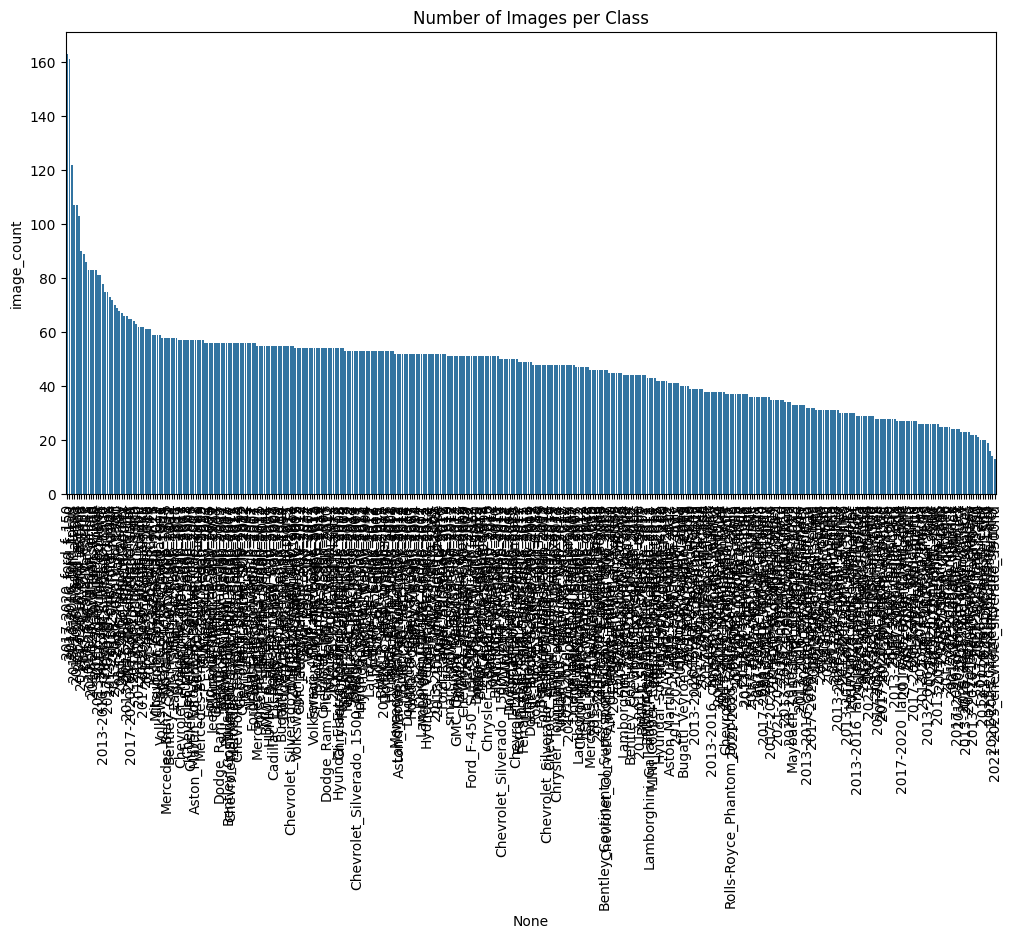

In [ ]:
# Plot class count distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=train_class_counts_df.index, y='image_count', data=train_class_counts_df)
plt.xticks(rotation=90)
plt.title('Number of Images per Class')
plt.show()

### Preprocess Images

In [ ]:
# Image dimensions and batch size
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

In [ ]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
# Loading data from directories
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_data = val_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 18397 images belonging to 391 classes.
Found 4798 images belonging to 391 classes.
Found 5931 images belonging to 391 classes.


### Build MobileNet Transfer Learning Model

In [ ]:
# Load the MobileNet base model
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze the base model layers
base_model.trainable = False

base_model.summary()

Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,228,864 (12.32 MB)

In [ ]:
# Build the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(391, activation='softmax')
])

# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Define callbacks
checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/MyDrive/Computer Vision Project/Models/mobilenet_model5.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1
)

callbacks = [early_stopping, checkpoint_callback, lr_scheduler]

### Train Model

In [ ]:
# Train the model
EPOCHS = 50

history = model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=val_data,
    callbacks=callbacks
)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


574/575 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.0571 - loss: 9.3348
Epoch 1: val_loss improved from inf to 5.44838, saving model to /content/drive/MyDrive/Computer Vision Project/Models/mobilenet_model5.keras
575/575 ━━━━━━━━━━━━━━━━━━━━ 319s 531ms/step - accuracy: 0.0573 - loss: 9.3272 - val_accuracy: 0.1371 - val_loss: 5.4484 - learning_rate: 0.0010
Epoch 2/50
574/575 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.2288 - loss: 4.5173
Epoch 2: val_loss improved from 5.44838 to 4.44230, saving model to /content/drive/MyDrive/Computer Vision Project/Models/mobilenet_model5.keras
575/575 ━━━━━━━━━━━━━━━━━━━━ 282s 476ms/step - accuracy: 0.2288 - loss: 4.5170 - val_accuracy: 0.2159 - val_loss: 4.4423 - learning_rate: 0.0010
Epoch 3/50
574/575 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.2930 - loss: 4.0069
Epoch 3: val_loss improved from 4.44230 to 3.84519, saving model to /content/drive/MyDrive/Computer Vision Project/Models/mobilenet_model5.keras
575/575 ━━━━━━━━━━━━━━━━━━

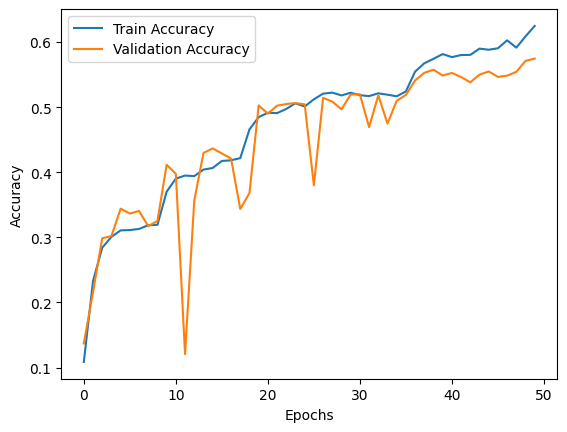

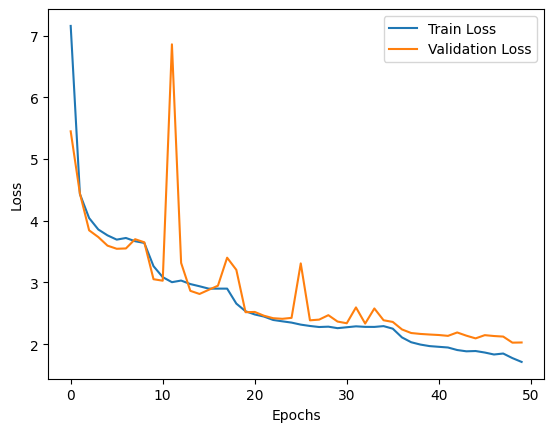

In [ ]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model Tracking

mobilenet_model1 - base model using unfiltered model data
- Test Loss: 2.2718491554260254
- Test Accuracy: 0.4571875035762787
- Notes: A bit overfit. Includes images that are not of cars. Scraped Classes have worse accuracy in general.

mobilenet_model2 - base model using data filtered with confidence = 0.7
- Test Loss: 2.2470030784606934
- Test Accuracy: 0.46014031767845154
- Notes: Still overfitting. Still some images not of cars. Scraped classes still have worse accuracy.

mobilenet_model3 - base model using data filtered with confidence = 0.85
- Test Loss: 2.134223699569702
- Test Accuracy: 0.46547773480415344
- Notes: Still overfitting. Still some images not of cars. Scraped classes still have worse accuracy.

mobilenet_model4 - base model using data filtered with confidence = 0.9
- Test Loss: 2.125551462173462
- Test Accuracy: 0.4695945978164673
- Notes: Still overfitting. Most images of cars. Scraped classes still have worse accuracy.

mobilenet_model5 - First tuned model (confidence = 0.9)
- Data augmentation
- BatchNorm
- l2 regularization
- Dropout increased to 0.4
- LR scheduling
- 50 epochs instead of 30
- Test Loss: 1.916022539138794
- Test Accuracy: 0.6000000238418579

mobilenet5_fine_tuned_model - Fine Tuned Version of model5
- Unfroze last 16 layers of MobileNet
- MobileNet has 86 layers to begin with
- Test Loss: 1.7010222673416138
- Test Accuracy: 0.6283783912658691

### Evaluate the Model on Test set

In [ ]:
# Load model
model = tf.keras.models.load_model('/content/drive/MyDrive/Computer Vision Project/Models/mobilenet_model5.keras')

In [ ]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(test_data, steps=test_data.samples // BATCH_SIZE)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


185/185 ━━━━━━━━━━━━━━━━━━━━ 27s 144ms/step - accuracy: 0.4836 - loss: 2.4562
Test Loss: 1.916022539138794
Test Accuracy: 0.6000000238418579


In [ ]:
# Reset the test generator and make predictions
test_data.reset()
predictions = model.predict(test_data, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = test_data.classes

# Define class labels
class_indices = test_data.class_indices  # Get class-to-index mapping
class_labels_dict = {v: k for k, v in class_indices.items()}  # Reverse to index-to-class mapping

# Create a sorted list of class labels
class_labels = [class_labels_dict[i] for i in sorted(class_labels_dict.keys())]

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

print('Confusion Matrix')
print(cm)

# Print sorted class labels
print('Class Labels:', class_labels)

186/186 ━━━━━━━━━━━━━━━━━━━━ 20s 100ms/step
Confusion Matrix
[[ 3  0  0 ...  0  0  0]
 [ 0  3  0 ...  0  0  0]
 [ 0  0  2 ...  0  0  0]
 ...
 [ 0  0  0 ... 10  0  0]
 [ 0  0  0 ...  0 13  0]
 [ 0  0  0 ...  0  0 16]]
Class Labels: ['2013-2016_acura_mdx', '2013-2016_audi_allroad_quattro', '2013-2016_audi_tt_rs', '2013-2016_bmw_3_series', '2013-2016_bmw_4_series', '2013-2016_bmw_5_series', '2013-2016_bmw_x5', '2013-2016_bmw_z8', '2013-2016_cadillac_ats', '2013-2016_cadillac_srx', '2013-2016_chevrolet_camaro', '2013-2016_chevrolet_cruze', '2013-2016_chevrolet_equinox', '2013-2016_chevrolet_express', '2013-2016_chevrolet_express_cargo', '2013-2016_chevrolet_impala', '2013-2016_chevrolet_malibu', '2013-2016_chevrolet_silverado_1500', '2013-2016_chevrolet_silverado_1500_ld', '2013-2016_chevrolet_silverado_ev', '2013-2016_chevrolet_suburban', '2013-2016_chevrolet_tahoe', '2013-2016_chevrolet_traverse', '2013-2016_chrysler_200', '2013-2016_chrysler_town_and_country', '2013-2016_dodge_charger',

In [ ]:
# Classification Report
print('\nClassification Report')
print(classification_report(y_true, y_pred, target_names=class_labels))

# Compute F1 Score
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'\nWeighted F1 Score: {f1:.4f}')


Classification Report
                                                        precision    recall  f1-score   support

                                   2013-2016_acura_mdx       1.00      0.30      0.46        10
                        2013-2016_audi_allroad_quattro       0.75      0.30      0.43        10
                                  2013-2016_audi_tt_rs       0.40      0.20      0.27        10
                                2013-2016_bmw_3_series       0.44      0.36      0.40        11
                                2013-2016_bmw_4_series       0.27      0.30      0.29        10
                                2013-2016_bmw_5_series       0.25      0.18      0.21        11
                                      2013-2016_bmw_x5       0.33      0.33      0.33         9
                                      2013-2016_bmw_z8       0.67      0.60      0.63        20
                                2013-2016_cadillac_ats       0.17      0.40      0.24        10
                

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Remove the Filtered folder and its contents
!rm -rf /content/dataset/Filtered

### Fine-tuning

In [ ]:
# Fine-tuning
# Unfreeze some of the layers in the base model
base_model.trainable = True

# Freeze the first few layers to avoid overfitting
for layer in base_model.layers[:70]:
    layer.trainable = False

# Recompile the model with a lower learning rate
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

checkpoint_callback_fine_tune = ModelCheckpoint(
    filepath='/content/drive/MyDrive/Computer Vision Project/Models/mobilenet5_fine_tuned_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

EPOCHS = 50

# Continue training with fine-tuning
fine_tune_history = model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=val_data,
    callbacks=[early_stopping, checkpoint_callback_fine_tune, lr_scheduler]
)

Epoch 1/50
574/575 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.6109 - loss: 1.7378
Epoch 1: val_loss improved from inf to 2.08064, saving model to /content/drive/MyDrive/Computer Vision Project/Models/mobilenet5_fine_tuned_model.keras
575/575 ━━━━━━━━━━━━━━━━━━━━ 320s 543ms/step - accuracy: 0.6109 - loss: 1.7380 - val_accuracy: 0.5519 - val_loss: 2.0806 - learning_rate: 1.0000e-04
Epoch 2/50
574/575 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.6069 - loss: 1.7597
Epoch 2: val_loss improved from 2.08064 to 2.05305, saving model to /content/drive/MyDrive/Computer Vision Project/Models/mobilenet5_fine_tuned_model.keras
575/575 ━━━━━━━━━━━━━━━━━━━━ 285s 490ms/step - accuracy: 0.6069 - loss: 1.7598 - val_accuracy: 0.5621 - val_loss: 2.0531 - learning_rate: 1.0000e-04
Epoch 3/50
574/575 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.6047 - loss: 1.7742
Epoch 3: val_loss did not improve from 2.05305
575/575 ━━━━━━━━━━━━━━━━━━━━ 281s 481ms/step - accuracy: 0.6046 - loss: 1.7743 - va

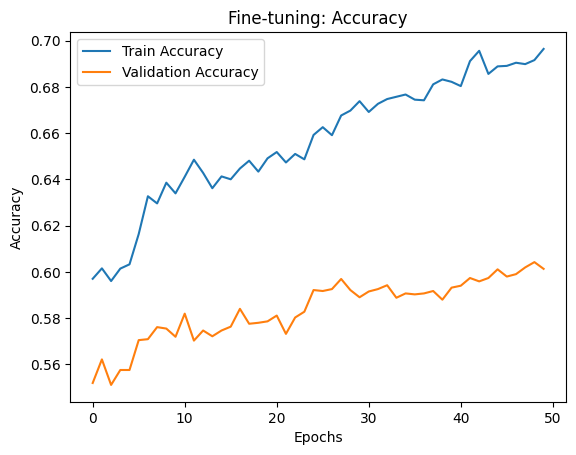

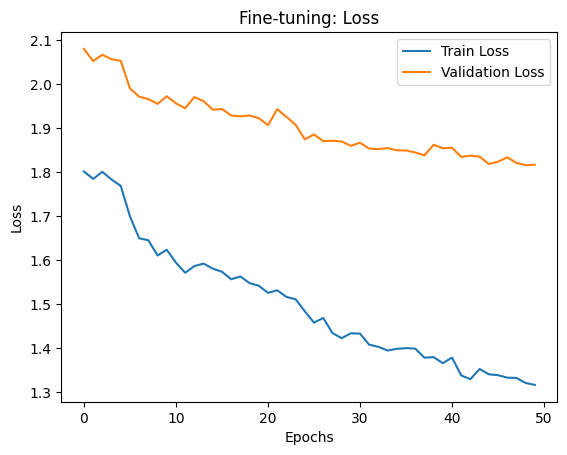

In [ ]:
# Plot accuracy for fine-tuning
plt.plot(fine_tune_history.history['accuracy'], label='Train Accuracy')
plt.plot(fine_tune_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Fine-tuning: Accuracy')
plt.legend()
plt.show()

# Plot loss for fine-tuning
plt.plot(fine_tune_history.history['loss'], label='Train Loss')
plt.plot(fine_tune_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Fine-tuning: Loss')
plt.legend()
plt.show()


In [ ]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(test_data, steps=test_data.samples // BATCH_SIZE)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


185/185 ━━━━━━━━━━━━━━━━━━━━ 27s 144ms/step - accuracy: 0.5206 - loss: 2.2282
Test Loss: 1.7010222673416138
Test Accuracy: 0.6283783912658691


### Compare Stanford classes with Scraped Classes

In [ ]:
# Load model
model = tf.keras.models.load_model('/content/drive/MyDrive/Computer Vision Project/Models/mobilenet5_fine_tuned_model.keras')

In [ ]:
from tensorflow.keras.models import load_model

def evaluate_with_class_types(model, generator, save_path):
    """
    Evaluate model on the full test generator but analyze Stanford and scraped classes separately
    """
    # Get predictions for full dataset
    steps = int(np.ceil(generator.samples / generator.batch_size))
    predictions = model.predict(generator, steps=steps, verbose=1)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = generator.classes[:len(predicted_classes)]

    # Get class mappings
    class_indices = generator.class_indices
    idx_to_class = {v: k for k, v in class_indices.items()}

    # Separate classes into Stanford and scraped
    stanford_class_indices = []
    scraped_class_indices = []

    for idx, class_name in idx_to_class.items():
        if any(class_name.startswith(str(year)) for year in range(1900, 2024)):
            scraped_class_indices.append(idx)
        else:
            stanford_class_indices.append(idx)

    def analyze_class_set(class_indices, name):
        # Get mask for samples belonging to this set
        mask = np.isin(true_classes, class_indices)
        set_true = true_classes[mask]
        set_pred = predicted_classes[mask]

        # Calculate per-class accuracy
        per_class_accuracy = {}
        for class_idx in class_indices:
            class_mask = set_true == class_idx
            if np.sum(class_mask) > 0:
                class_name = idx_to_class[class_idx]
                accuracy = np.mean(set_pred[class_mask] == set_true[class_mask])
                per_class_accuracy[class_name] = accuracy

        # Convert to DataFrame
        performance_df = pd.DataFrame({
            'Class': list(per_class_accuracy.keys()),
            'Accuracy': list(per_class_accuracy.values())
        })

        # Get top and bottom 5
        top_5 = performance_df.nlargest(5, 'Accuracy')
        bottom_5 = performance_df.nsmallest(5, 'Accuracy')

        # Overall accuracy for this set
        set_accuracy = np.mean(set_pred == set_true)

        # Save results
        with open(os.path.join(save_path, f'{name}_evaluation.txt'), 'w') as f:
            f.write(f"===== {name.upper()} CLASSES EVALUATION =====\n\n")
            f.write(f"Total Classes: {len(class_indices)}\n")
            f.write(f"Total Samples: {np.sum(mask)}\n")
            f.write(f"Overall Accuracy: {set_accuracy:.4f}\n\n")

            f.write("TOP 5 BEST CLASSIFIED CARS:\n")
            f.write("===========================\n")
            for _, row in top_5.iterrows():
                f.write(f"{row['Class']:<40} ({row['Accuracy']:.4f})\n")

            f.write("\nBOTTOM 5 WORST CLASSIFIED CARS:\n")
            f.write("==============================\n")
            for _, row in bottom_5.iterrows():
                f.write(f"{row['Class']:<40} ({row['Accuracy']:.4f})\n")

        return set_accuracy, len(class_indices), np.sum(mask)

    # Analyze both sets
    print("\nAnalyzing results...")
    stanford_acc, stanford_classes, stanford_samples = analyze_class_set(stanford_class_indices, "stanford")
    scraped_acc, scraped_classes, scraped_samples = analyze_class_set(scraped_class_indices, "scraped")

    # Print summary
    print("\nResults Summary:")
    print(f"Stanford Classes: {stanford_classes} classes, {stanford_samples} samples, {stanford_acc:.4f} accuracy")
    print(f"Scraped Classes: {scraped_classes} classes, {scraped_samples} samples, {scraped_acc:.4f} accuracy")

# Load model
print("Loading model...")
model_path = "/content/drive/MyDrive/Computer Vision Project/Models/mobilenet5_fine_tuned_model.keras"
loaded_model = load_model(model_path)

# Create save directory if it doesn't exist
save_path = "/content/drive/MyDrive"
os.makedirs(save_path, exist_ok=True)

# Evaluate the data
print("Evaluating test data...")
evaluate_with_class_types(loaded_model, test_data, save_path)

print("\nEvaluation completed! Results saved to:")
print(f"{save_path}/stanford_evaluation.txt")
print(f"{save_path}/scraped_evaluation.txt")

Loading model...
Evaluating test data...


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


186/186 ━━━━━━━━━━━━━━━━━━━━ 28s 118ms/step

Analyzing results...

Results Summary:
Stanford Classes: 195 classes, 3264 samples, 0.7472 accuracy
Scraped Classes: 196 classes, 2667 samples, 0.4844 accuracy

Evaluation completed! Results saved to:
/content/drive/MyDrive/stanford_evaluation.txt
/content/drive/MyDrive/scraped_evaluation.txt
